In [1]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [103]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import gunshot_utils as utils
import importlib
import ast
import re
import pickle

import torch as th
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

importlib.reload(utils)

<module 'gunshot_utils' from '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/gunshot_utils.py'>

In [3]:
# Model descrbied in the paper plus droput
class OnsetDetectionCNN(nn.Module):
    def __init__(self):
        super(OnsetDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))
        self.fc1 = nn.Linear(20 * 7 * 8, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 7 * 8)
        x = self.dropout(F.relu(self.fc1(x)))  # Apply dropout
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = OnsetDetectionCNN()

In [4]:
class GunshotDataset(th.utils.data.Dataset):
    def __init__(self, spectograms, sample_rates, targets):
        self.X = []
        self.y = []

        for X, sample_rate, y in zip(spectograms, sample_rates, targets):
            X_frames, y_frames = utils.make_frames(X, y)
            self.X += X_frames
            self.y += y_frames

        tmp = th.cat(self.X)
        self.mean = th.mean(tmp, dim=(0, 2)).unsqueeze(1)
        self.std = th.std(tmp, dim=(0, 2)).unsqueeze(1)
        del tmp

        self.X = [(x - self.mean)/self.std for x in self.X]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

<b>Gunshot dataset</b>

In [5]:
gunshots = pd.read_csv('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Audio/Gunshots/7004819/edge-collected-gunshot-audio/gunshot-audio-all-metadata.csv')
gunshots = gunshots[['filename', 'num_gunshots', 'gunshot_location_in_seconds']]

# This function is needed because for some reason the gunshots start list is treated as string for some reason.
def preprocess_gunshot_times(gunshot_times):
    # Remove multiple spaceS
    gunshot_times = re.sub(r'\s+', ' ', gunshot_times).strip()

    # Insert commas between numbers if missing
    gunshot_times = re.sub(r'(?<=\d)\s(?=\d)', ', ', gunshot_times)

    # Ensure there are no trailing commas
    gunshot_times = gunshot_times.replace(', ]', ']')

    # Safely evaluate the string as a list
    try:
        return ast.literal_eval(gunshot_times)
    except (ValueError, SyntaxError):
        # Return an empty list if the string is not a valid list
        return []
    
# # Apply the function to the 'gunshot_location_in_seconds' column
gunshots['gunshot_location_in_seconds'] = gunshots['gunshot_location_in_seconds'].apply(preprocess_gunshot_times)

In [6]:
root_path = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Audio/Gunshots/7004819/edge-collected-gunshot-audio/edge-collected-gunshot-audio/'

def change_filename(filename):
    return root_path + filename + '.wav'

In [7]:
gunshots['filename'] = gunshots['filename'].apply(change_filename)

In [8]:
gunshots['label'] = 1

<b>Musical dataset</b>

In [9]:
music = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data_w_topics_w_features.xlsx', engine='openpyxl')

In [10]:
music = music.rename(columns={'Path': 'filename'})
music = music[['filename']]
music['num_gunshots'] = 0
music['gunshot_location_in_seconds'] = 0
music['label'] = 0

In [11]:
df = pd.concat([gunshots, music])

In [12]:
files = df[['filename', 'num_gunshots', 'gunshot_location_in_seconds']]
labels = df[['label']]

In [13]:
X_train_paths, X_test_paths, y_train_paths, y_test_paths = train_test_split(files, labels, test_size=0.3, random_state=42)

In [93]:
spectrograms_train, sample_rates_train, labels_train = utils.preprocess_audio_train(X_train_paths, max_non_gunshot_samples=10)
spectrograms_test, sample_rates_test, labels_test = utils.preprocess_audio_train(X_test_paths, max_non_gunshot_samples=10)

100%|██████████| 1054/1054 [02:44<00:00,  6.42it/s]


In [94]:
# 3 dimensions of mel-spectograms with 80 mel bands and 15 frames.
spectrograms_train[0].shape

torch.Size([3, 80, 15])

In [95]:
dataset = GunshotDataset(spectrograms_train, sample_rates_train, labels_train)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [96]:
print(len(dataset.X))
print(dataset.X[0].shape)

14021
torch.Size([3, 80, 15])


In [98]:
mean_std = {'mean': dataset.mean, 'std': dataset.std}
with open('mean_std.pkl', 'wb') as f:
    pickle.dump(mean_std, f)

# Save using torch
th.save({'mean': dataset.mean, 'std': dataset.std}, 'mean_std.pth')

In [99]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
print(device)

cpu


In [104]:
import torch as th
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings

device = th.device("cuda" if th.cuda.is_available() else "cpu")

def train_model(model, optimizer, criterion, train_loader, valid_features, valid_labels, epochs=10, thresholds=None, mean=None, std=None):
    if thresholds is None:
        thresholds = np.arange(0.1, 1.0, 0.05)  # Define a range of thresholds to test

    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)

    model = model.to(device)
    best_threshold = 0.0

    # I wrote score here because it depends on the metric we want to use.
    best_score = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Training phase
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device).float()

            optimizer.zero_grad()

            # Normalize features
            features = (features - mean) / std

            outputs = model(features)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validation phase
        model.eval()
        best_epoch_threshold, current_score = evaluate_model(model, valid_features, valid_labels, thresholds, mean, std)

        if current_score > best_score:
            best_score = current_score
            best_threshold = best_epoch_threshold
            print(f"New best F1 score: {best_score:.4f}, model saved.")

        print(f"TEST best_f1: {best_score} with best threshold: {best_threshold}")

    # Compute and display the confusion matrix on the validation set
    cm = compute_confusion_matrix(model, valid_features, valid_labels, best_threshold, mean, std)
    display_confusion_matrix(cm)

    return best_threshold, best_score

def evaluate_model(model, features, labels, thresholds, mean, std):
    best_threshold = 0.0
    best_f1_score = 0.0

    with th.no_grad():
        for threshold in thresholds:
            all_predictions = []
            all_labels = []

            for feature, label in zip(features, labels):
                feature = feature.to(device)
                label = th.tensor(label).float().to(device)  # Ensure label is a float tensor

                # Normalize feature
                feature = (feature - mean) / std

                # Get model predictions
                output = model(feature.unsqueeze(0)).squeeze().cpu().numpy()  # Add batch dimension

                # Apply threshold
                predictions = (output >= threshold).astype(float)

                all_predictions.append(predictions)
                all_labels.append(label.item())

            # Calculate F1 score
            avg_f1_score = f1_score(all_labels, all_predictions)

            if avg_f1_score > best_f1_score:
                best_f1_score = avg_f1_score
                best_threshold = threshold

    return best_threshold, best_f1_score

def compute_confusion_matrix(model, features, labels, threshold, mean, std):
    all_predictions = []
    all_labels = []

    model.eval()
    with th.no_grad():
        for feature, label in zip(features, labels):
            feature = feature.to(device)
            label = th.tensor(label).float().to(device)  # Ensure label is a float tensor

            # Normalize feature
            feature = (feature - mean) / std

            # Get model predictions
            output = model(feature.unsqueeze(0)).squeeze().cpu().numpy()  # Add batch dimension

            # Apply threshold
            predictions = (output >= threshold).astype(float)

            all_predictions.append(predictions)
            all_labels.append(label.item())

    cm = confusion_matrix(all_labels, all_predictions)
    return cm

def display_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()

def evaluate_model_accuracy(model, features, labels, thresholds, mean, std):
    best_threshold = 0.0
    best_accuracy = 0.0

    with th.no_grad():
        for threshold in thresholds:
            all_accuracies = []

            for feature, label in zip(features, labels):
                feature = feature.to(device)
                label = th.tensor(label).to(device)  # Ensure label is a tensor

                # Normalize feature
                feature = (feature - mean) / std

                # Get model predictions
                output = model(feature).squeeze().cpu().numpy()  # Add batch dimension

                # Apply threshold
                predictions = (output >= threshold).astype(float)

                # Calculate accuracy
                accuracy = accuracy_score([label.item()], [predictions.item()])

                all_accuracies.append(accuracy)

            avg_accuracy = np.mean(all_accuracies)
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_threshold = threshold

    return best_threshold, best_accuracy

# Example usage:
# Assuming you have your model, optimizer, criterion, and data loaders defined
# mean and std should be calculated from the training data
# train_loader


Epoch [1/50], Loss: 7.7661
New best F1 score: 0.9823, model saved.
TEST best_f1: 0.9823434991974317 with best threshold: 0.15000000000000002
Epoch [2/50], Loss: 6.3476
TEST best_f1: 0.9823434991974317 with best threshold: 0.15000000000000002
Epoch [3/50], Loss: 5.6378
New best F1 score: 0.9859, model saved.
TEST best_f1: 0.985945945945946 with best threshold: 0.7000000000000002
Epoch [4/50], Loss: 5.1058
TEST best_f1: 0.985945945945946 with best threshold: 0.7000000000000002
Epoch [5/50], Loss: 4.8235
TEST best_f1: 0.985945945945946 with best threshold: 0.7000000000000002
Epoch [6/50], Loss: 4.4873
New best F1 score: 0.9887, model saved.
TEST best_f1: 0.9887036040882194 with best threshold: 0.1
Epoch [7/50], Loss: 4.0676
New best F1 score: 0.9909, model saved.
TEST best_f1: 0.9908651262761956 with best threshold: 0.1
Epoch [8/50], Loss: 3.9632
New best F1 score: 0.9914, model saved.
TEST best_f1: 0.991393222162453 with best threshold: 0.1
Epoch [9/50], Loss: 3.8576
TEST best_f1: 0.9913

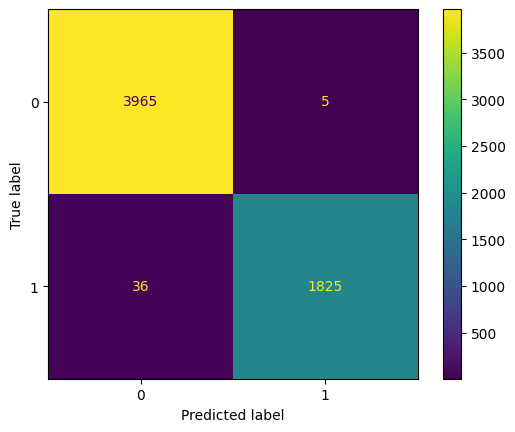

In [105]:
epochs = 100
lr = 3e-4

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

best_threshold, best_f1 = train_model(model, optimizer, criterion, dataloader, spectrograms_test, labels_test, epochs=50, thresholds=None, mean=dataset.mean, std=dataset.std)

In [106]:
def manual_evaluate_test(model, feature, threshold, frame_size=15, mean=None, std=None):
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)

    model = model.to(device)
    model.eval()

    with th.no_grad():
        predictions = []

        # Prepare features
        num_frames = feature.shape[2]
        feature = feature.to(device)
        feature = (feature - mean) / std  # Normalize the feature

        # Loop through non-overlapping frames
        for j in range(0, num_frames - frame_size + 1, frame_size):
            start = j
            end = j + frame_size

            input_frame = feature[:, :, start:end].unsqueeze(0).float()  # Add batch dimension
            output = model(input_frame).squeeze().item()
            predictions.append(output)

        res = []
        for idx in range(len(predictions)):
            if predictions[idx] >= threshold:
                time_in_seconds = idx * frame_size * utils.HOP_LENGTH / utils.SAMPLING_RATE
                minutes = int(time_in_seconds // 60)
                seconds = time_in_seconds % 60
                res.append((minutes, seconds))

    return res

In [107]:
best_threshold

0.6500000000000001

In [146]:
spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Downloads/50 Cent - Heat (Official Music Video).mp3'])

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


In [147]:
spectrograms[0].shape

torch.Size([3, 80, 22537])

In [148]:
# model.load_state_dict(th.load('./best_model.pth'))
# model.eval()

In [149]:
# Load mean and std from file
with open('./mean_std.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std = data['std']

In [150]:
for spectogram in spectrograms:
    predicted_times = manual_evaluate_test(model, spectogram, threshold=best_threshold, mean=mean, std=std)

In [151]:
for time in predicted_times:
    print(f"Prediction at {time[0]} minutes and {time[1]} seconds")

Prediction at 0 minutes and 31.172789115646257 seconds
Prediction at 0 minutes and 33.262585034013604 seconds
Prediction at 1 minutes and 21.15374149659864 seconds
Prediction at 1 minutes and 36.82721088435375 seconds
Prediction at 2 minutes and 53.278911564625844 seconds
Prediction at 3 minutes and 26.889795918367355 seconds


0.6500000000000001